# 1. 先用預訓練好的神經網路提取影片特徵

In [39]:
import cv2
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

In [42]:
import tensorflow as tf
# 设置 TensorFlow 使用 GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

: 

In [27]:
# VGG16 model，只做到特徵提取
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [33]:
# Load dataset
dataset_dir = './dataset'

dataset = []
for category in os.listdir(dataset_dir):
    shape = (1, len(os.listdir(os.path.join(dataset_dir, category))))
    print(shape)
    shuffle = np.ones(shape)
    shuffle[0, np.random.choice(shape[1], size=shape[1]//2, replace=False)] = 0

    video_count = 0 # 計算這個類別有幾個影片
    category_path = os.path.join(dataset_dir, category)
    for index, video in enumerate(os.listdir(category_path)):
        video_path = os.path.join(category_path, video)
        if not os.path.isdir(video_path):
            continue
        if shuffle[0, index] == 0:
            continue

        frames = []
        cnt = -1
        for frame in os.listdir(video_path):
            cnt += 1
            if cnt % 3 != 0:
                continue
            frame_path = os.path.join(video_path, frame)
            img = cv2.imread(frame_path)
            img = np.expand_dims(img, axis=0)  # 拓展維度
            img = preprocess_input(img)  # 預處理
            frames.append(img)

        dataset.append(frames)


(1, 2028)
(1, 1976)
(1, 1716)
(1, 1560)
(1, 2288)
(1, 2392)


In [34]:
# 提取特徵
print(len(dataset))
dataset = np.array(dataset)
print(dataset.shape)

videos_features = []
for data in dataset:
    features = []
    for frame in data:
        print(frame.shape)
        feature = model.predict(frame)
        features.append(feature)
    videos_features.append(np.concatenate(features, axis=0))
    print(len(videos_features))


5876
(5876, 10, 1, 90, 160, 3)
(1, 90, 160, 3)
1/1 [==============================] - 1s 1s/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 156ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 62ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 87ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 53ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 51ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 60ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 49ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 124ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 52ms/step
1
(1, 90, 160, 3)
1/1 [==============================] - 0s 76ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 77ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 52ms/step
(1, 90, 160, 3)
1/1 [==============================] - 0s 70ms/step
(1, 90, 160, 3)

KeyboardInterrupt: 

# 1. 用OpenCV提取影片的光流

In [1]:
import cv2
import os
import numpy as np

In [2]:
def extract_optical_flow(frames):
    features = []

    prev_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    for frame in frames[1:]:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        flow_feature = flow.reshape(-1)
        features.append(flow_feature)

        prev_frame = gray
    
    return np.array(features)

In [3]:
# 提取影片光流
dataset_dir = './dataset_aug'

videos_features = [] # 存所有data特徵向量的特徵陣列
label_list = [] # 存每個類別的影片數量

for label, category in enumerate(os.listdir(dataset_dir)):
    video_count = 0 # 計算這個類別有幾個影片
    category_path = os.path.join(dataset_dir, category)
    for video in os.listdir(category_path):
        video_path = os.path.join(category_path, video)
        if not os.path.isdir(video_path):
            continue
        video_count += 1
        label_list.append(label)

        frames = []
        for frame in os.listdir(video_path):
            frame = cv2.imread(os.path.join(video_path, frame))
            frame = cv2.resize(frame, (160, 90))  # resize
            frames.append(frame)
            
        features = extract_optical_flow(frames)
        videos_features.append(features)
    

In [4]:
videos_features = np.array(videos_features)
print(videos_features.shape)

(1200, 29, 28800)


# 2. 再用DBSCAN分群

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [62]:
data = np.array(videos_features)
X = data.reshape((data.shape[0], -1))
print(X.shape)

# PCA降維
# pca = PCA(n_components=100)
# X = pca.fit_transform(X)
# print(X.shape)

(229, 835200)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1  0  0  0 -1 -1  0  0  0 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0
 -1 -1  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0  0 -1  0  0  0 -1 -1 -1  0  0  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0  0 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0 -1 -1 -1  0 -1  0 -1  0 -1  0 -1 -1
 -1 -1  0  0 -1  0  0  0  0  0 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0]
number of different label:  2
number of noise:  163


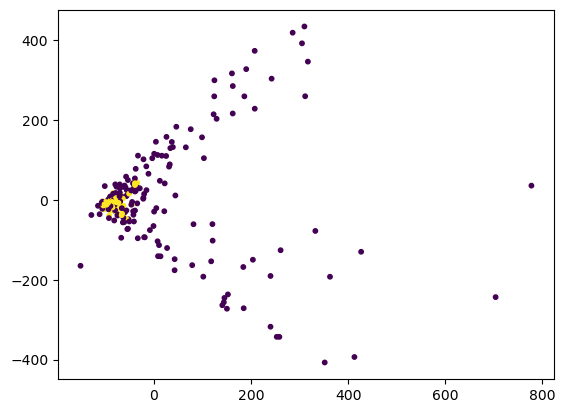

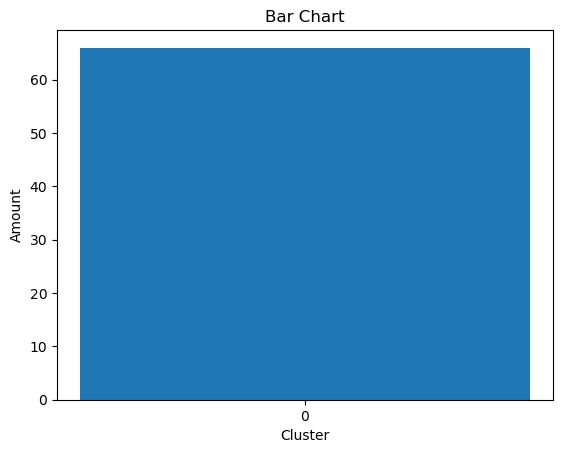

In [60]:
# 調整DBSCAN參數
eps = 300  # 範圍
min_samples = 6  # 成為核心的最小點數

# 應用DBSCAN算法
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)
print(dbscan.labels_)
print("number of different label: ", len(set(labels.tolist())))
print("number of noise: ", labels.tolist().count(-1))
# plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
# labels 中的每个值表示对应数据点的簇标签，-1 表示噪声点

# 分析分群結果
# plt.scatter(pca_X[:, 0], pca_X[:, 1], c=labels, cmap='viridis')
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
plt.scatter(pca_X[:, 0], pca_X[:, 1], s=10 ,c=labels, cmap='viridis')
plt.show()
# 绘制直方图
bar = []
i = 0
while labels.tolist().count(i) != 0:
    bar.append(labels.tolist().count(i))
    i += 1
categories = [f'{i}' for i in range(0, len(bar))]

plt.bar(categories, bar)

# 添加标题和标签
plt.title('Bar Chart')
plt.xlabel('Cluster')
plt.ylabel('Amount')

# 显示图形
plt.show()

# 2. K means

In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
data = np.array(videos_features)
X = data.reshape((data.shape[0], -1))
print(X.shape)

# pca = PCA(n_components=200)
# X = pca.fit_transform(X)
# print(X.shape)

(1200, 835200)


In [ ]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
Y = kmeans.labels_

(1200, 2)


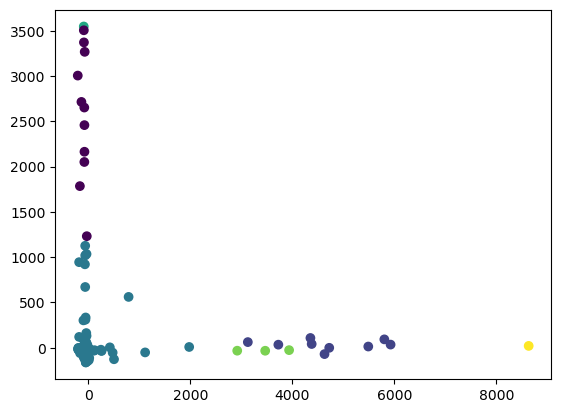

In [142]:
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
print(pca_X.shape)

plt.scatter(pca_X[:, 0], pca_X[:, 1], c=Y)

In [125]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[2 2 2 ... 2 2 2]
label 0 is assigned to class 5
label 1 is assigned to class 4
label 2 is assigned to class 3
label 3 is assigned to class 0
label 4 is assigned to class 1
label 5 is assigned to class 2
[[  2   1 193   1   2   1]
 [  0   1 199   0   0   0]
 [  1   3 196   0   0   0]
 [  2   1 197   0   0   0]
 [  5   1 193   0   1   0]
 [  1   2 197   0   0   0]]
Confusion matrix, without normalization
[[  2   1 193   1   2   1]
 [  0   1 199   0   0   0]
 [  1   3 196   0   0   0]
 [  2   1 197   0   0   0]
 [  5   1 193   0   1   0]
 [  1   2 197   0   0   0]]


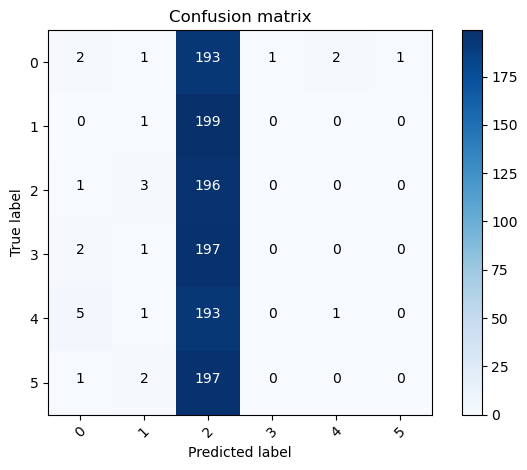

In [143]:
print(Y)

from sklearn.metrics import accuracy_score, confusion_matrix

double_hit = Y[:200]
holding = Y[200:400]
out_ball = Y[400:600]
rotational_fault = Y[600:800]
touch_net = Y[800:1000]
touch_out = Y[1000:]

arr_2d = []
arr_2d.append(double_hit.tolist())
arr_2d.append(holding.tolist())
arr_2d.append(out_ball.tolist())
arr_2d.append(rotational_fault.tolist())
arr_2d.append(touch_net.tolist())
arr_2d.append(touch_out.tolist())

is_assigned = [0, 0, 0, 0, 0, 0]
max_classes = []
for i in range(6):
    max_count = -1.0
    max_class = -1
    for j in range(6):
        if is_assigned[j] == 1:
            continue
        if arr_2d[j].count(i) > max_count:
            max_count = float(arr_2d[j].count(i) / len(arr_2d[j]))
            max_class = j
    is_assigned[max_class] = 1
    max_classes.append(max_class)
    print(f"label {i} is assigned to class {max_class}")

y_test = [max_classes[0]]*200 + [max_classes[1]]*200 + [max_classes[2]]*200 + [max_classes[3]]*200 + [max_classes[4]]*200 + [max_classes[5]]*200
cnf_matrix_sklearn = confusion_matrix(y_test, Y)
print(cnf_matrix_sklearn)
plot_confusion_matrix(cnf_matrix_sklearn, [0, 1, 2, 3, 4, 5], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)